In [8]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from datetime import datetime

In [12]:
'''Persistence Model Forecast
A good baseline forecast for a time series with a linear increasing trend is a persistence forecast.

The persistence forecast is where the observation from the prior time step (t-1) is used to predict the observation at the current time step (t).

We can implement this by taking the last observation from the training data and history accumulated by walk-forward validation and using that to predict the current time step.

For example:

# make prediction
yhat = history[-1]
1
2
# make prediction
yhat = history[-1]
We will accumulate all predictions in an array so that they can be directly compared to the test dataset.

The complete example of the persistence forecast model on the Shampoo Sales dataset is listed below.'''

'Persistence Model Forecast\nA good baseline forecast for a time series with a linear increasing trend is a persistence forecast.\n\nThe persistence forecast is where the observation from the prior time step (t-1) is used to predict the observation at the current time step (t).\n\nWe can implement this by taking the last observation from the training data and history accumulated by walk-forward validation and using that to predict the current time step.\n\nFor example:\n\n# make prediction\nyhat = history[-1]\n1\n2\n# make prediction\nyhat = history[-1]\nWe will accumulate all predictions in an array so that they can be directly compared to the test dataset.\n\nThe complete example of the persistence forecast model on the Shampoo Sales dataset is listed below.'

RMSE: 136.761


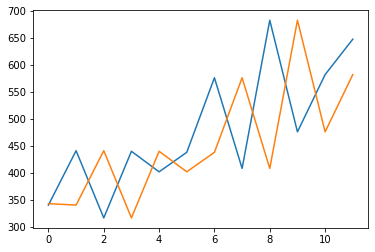

'A line plot of the test dataset (blue) compared to the predicted values (orange) is also created showing the persistence model forecast in context.'

In [13]:

from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# split data into train and test
X = series.values
train, test = X[0:-12], X[-12:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# make prediction
	predictions.append(history[-1])
	# observation
	history.append(test[i])
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()


'''A line plot of the test dataset (blue) compared to the predicted values (orange) is also created showing the persistence model forecast in context.'''

In [14]:
'''LSTM Data Preparation
Before we can fit an LSTM model to the dataset, we must transform the data.

This section is broken down into three steps:

Transform the time series into a supervised learning problem
Transform the time series data so that it is stationary.
Transform the observations to have a specific scale.
Transform Time Series to Supervised Learning
The LSTM model in Keras assumes that your data is divided into input (X) and output (y) components.

For a time series problem, we can achieve this by using the observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output.

We can achieve this using the shift() function in Pandas that will push all values in a series down by a specified number places. We require a shift of 1 place, which will become the input variables. The time series as it stands will be the output variables.

We can then concatenate these two series together to create a DataFrame ready for supervised learning. The pushed-down series will have a new position at the top with no value. A NaN (not a number) value will be used in this position. We will replace these NaN values with 0 values, which the LSTM model will have to learn as “the start of the series” or “I have no data here,” as a month with zero sales on this dataset has not been observed.

The code below defines a helper function to do this called timeseries_to_supervised(). It takes a NumPy array of the raw time series data and a lag or number of shifted series to create and use as inputs.'''

'LSTM Data Preparation\nBefore we can fit an LSTM model to the dataset, we must transform the data.\n\nThis section is broken down into three steps:\n\nTransform the time series into a supervised learning problem\nTransform the time series data so that it is stationary.\nTransform the observations to have a specific scale.\nTransform Time Series to Supervised Learning\nThe LSTM model in Keras assumes that your data is divided into input (X) and output (y) components.\n\nFor a time series problem, we can achieve this by using the observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output.\n\nWe can achieve this using the shift() function in Pandas that will push all values in a series down by a specified number places. We require a shift of 1 place, which will become the input variables. The time series as it stands will be the output variables.\n\nWe can then concatenate these two series together to create a DataFrame ready for

In [15]:
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [16]:
'''We can test this function with our loaded Shampoo Sales dataset and convert it into a supervised learning problem.'''

'We can test this function with our loaded Shampoo Sales dataset and convert it into a supervised learning problem.'

In [17]:
from pandas import datetime
from pandas import DataFrame
from pandas import concat
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# transform to supervised learning
X = series.values
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

       0      0
0    0.0  266.0
1  266.0  145.9
2  145.9  183.1
3  183.1  119.3
4  119.3  180.3


In [18]:
'''Transform Time Series to Stationary
The Shampoo Sales dataset is not stationary.

This means that there is a structure in the data that is dependent on the time. Specifically, there is an increasing trend in the data.

Stationary data is easier to model and will very likely result in more skillful forecasts.

The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score.

A standard way to remove a trend is by differencing the data. That is the observation from the previous time step (t-1) is subtracted from the current observation (t). 
This removes the trend and we are left with a difference series, or the changes to the observations from one time step to the next.

We can achieve this automatically using the diff() function in pandas. 
Alternatively, we can get finer grained control and write our own function to do this, 
which is preferred for its flexibility in this case.

Below is a function called difference() that calculates a differenced series. 
Note that the first observation in the series is skipped as there is no prior observation 
with which to calculate a differenced value.'''

'Transform Time Series to Stationary\nThe Shampoo Sales dataset is not stationary.\n\nThis means that there is a structure in the data that is dependent on the time. Specifically, there is an increasing trend in the data.\n\nStationary data is easier to model and will very likely result in more skillful forecasts.\n\nThe trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score.\n\nA standard way to remove a trend is by differencing the data. That is the observation from the previous time step (t-1) is subtracted from the current observation (t). \nThis removes the trend and we are left with a difference series, or the changes to the observations from one time step to the next.\n\nWe can achieve this automatically using the diff() function in pandas. \nAlternatively, we can get finer grained control and write our own function to do this, \nwhich is preferred for its flexibility in

In [19]:

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [20]:
'''We also need to invert this process in order to take forecasts made on the differenced series back into their original scale.

The function below, called inverse_difference(), inverts this operation.'''

'We also need to invert this process in order to take forecasts made on the differenced series back into their original scale.\n\nThe function below, called inverse_difference(), inverts this operation.'

In [21]:

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [22]:
'''We can test out these functions by differencing the whole series, then returning it to the original scale, as follows'''

'We can test out these functions by differencing the whole series, then returning it to the original scale, as follows'

In [23]:
from pandas import read_csv
from pandas import datetime
from pandas import Series
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
# transform to be stationary
differenced = difference(series, 1)
print(differenced.head())
# invert transform
inverted = list()
for i in range(len(differenced)):
	value = inverse_difference(series, differenced[i], len(series)-i)
	inverted.append(value)
inverted = Series(inverted)
print(inverted.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64
0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64
0    145.9
1    183.1
2    119.3
3    180.3
4    168.5
dtype: float64


In [24]:
'''
Running the example prints the first 5 rows of the loaded data, then the first 5 rows of the differenced series, then finally the first 5 rows with the difference operation inverted.

Note that the first observation in the original dataset was removed from the inverted difference data. Besides that, the last set of data matches the first as expected.
'''

'\nRunning the example prints the first 5 rows of the loaded data, then the first 5 rows of the differenced series, then finally the first 5 rows with the difference operation inverted.\n\nNote that the first observation in the original dataset was removed from the inverted difference data. Besides that, the last set of data matches the first as expected.\n'

In [25]:
from sklearn.preprocessing import MinMaxScaler
'''
Transform Time Series to Scale
Like other neural networks, LSTMs expect data to be within the scale of the activation function used by the network.

The default activation function for LSTMs is the hyperbolic tangent (tanh), which outputs values between -1 and 1. This is the preferred range for the time series data.

To make the experiment fair, the scaling coefficients (min and max) values must be calculated on the training dataset and applied to scale the test dataset and any forecasts. This is to avoid contaminating the experiment with knowledge from the test dataset, which might give the model a small edge.

We can transform the dataset to the range [-1, 1] using the MinMaxScaler class. Like other scikit-learn transform classes, it requires data provided in a matrix format with rows and columns. Therefore, we must reshape our NumPy arrays before transforming.

For example:
'''
#transform scale
X = series.values
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)



In [26]:
'''Again, we must invert the scale on forecasts to return the values back to the original 
scale so that the results can be interpreted and a comparable error score can be calculated.
'''# invert transform
inverted_X = scaler.inverse_transform(scaled_X)

In [27]:

from pandas import read_csv
from pandas import datetime
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
# transform scale
X = series.values
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)
scaled_series = Series(scaled_X[:, 0])
print(scaled_series.head())
# invert transform
inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = Series(inverted_X[:, 0])
print(inverted_series.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64
0   -0.478585
1   -0.905456
2   -0.773236
3   -1.000000
4   -0.783188
dtype: float64
0    266.0
1    145.9
2    183.1
3    119.3
4    180.3
dtype: float64


In [28]:
'''
LSTM Model Development
The Long Short-Term Memory network (LSTM) is a type of Recurrent Neural Network (RNN).

A benefit of this type of network is that it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input.

In Keras, this is referred to as stateful, and involves setting the “stateful” argument to “True” when defining an LSTM layer.

By default, an LSTM layer in Keras maintains state between data within one batch. A batch of data is a fixed-sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network. State in the LSTM layer between batches is cleared by default, therefore we must make the LSTM stateful. This gives us fine-grained control over when state of the LSTM layer is cleared, by calling the reset_states() function.

The LSTM layer expects input to be in a matrix with the dimensions: [samples, time steps, features].

Samples: These are independent observations from the domain, typically rows of data.
Time steps: These are separate time steps of a given variable for a given observation.
Features: These are separate measures observed at the time of observation.
We have some flexibility in how the Shampoo Sales dataset is framed for the network. We will keep it simple and frame the problem as each time step in the original sequence is one separate sample, with one timestep and one feature.

Given that the training dataset is defined as X inputs and y outputs, it must be reshaped into the Samples/TimeSteps/Features format, for example:
'''


'\nLSTM Model Development\nThe Long Short-Term Memory network (LSTM) is a type of Recurrent Neural Network (RNN).\n\nA benefit of this type of network is that it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input.\n\nIn Keras, this is referred to as stateful, and involves setting the “stateful” argument to “True” when defining an LSTM layer.\n\nBy default, an LSTM layer in Keras maintains state between data within one batch. A batch of data is a fixed-sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network. State in the LSTM layer between batches is cleared by default, therefore we must make the LSTM stateful. This gives us fine-grained control over when state of the LSTM layer is cleared, by calling the reset_states() function.\n\nThe LSTM layer expects input to be in a matrix with the dimensions: [samples, time steps, features].\n\nSamples: These

##Complete LSTM Example

In this section, we will fit an LSTM to the Shampoo Sales dataset and evaluate the model.

This will involve drawing together all of the elements from the prior sections. There are a lot of them, so let’s review:

Load the dataset from CSV file.
Transform the dataset to make it suitable for the LSTM model, including:
Transforming the data to a supervised learning problem.
Transforming the data to be stationary.
Transforming the data so that it has the scale -1 to 1.
Fitting a stateful LSTM network model to the training data.
Evaluating the static LSTM model on the test data.
Report the performance of the forecasts.
Some things to note about the example:

The scaling and inverse scaling behaviors have been moved to the functions scale() and invert_scale() for brevity.
The test data is scaled using the fit of the scaler on the training data, as is required to ensure the min/max values of the test data do not influence the model.
The order of data transforms was adjusted for convenience to first make the data stationary, then a supervised learning problem, then scaled.
Differencing was performed on the entire dataset prior to splitting into train and test sets for convenience. We could just as easily collect observations during the walk-forward validation and difference them as we go. I decided against it for readability.
The complete example is listed below.

Using TensorFlow backend.
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn


Month=1, Predicted=350.361083, Expected=339.700000
Month=2, Predicted=420.616485, Expected=440.400000
Month=3, Predicted=381.414947, Expected=315.900000
Month=4, Predicted=434.264066, Expected=439.300000
Month=5, Predicted=427.587543, Expected=401.300000
Month=6, Predicted=488.314700, Expected=437.400000
Month=7, Predicted=455.106102, Expected=575.500000
Month=8, Predicted=457.316834, Expected=407.600000
Month=9, Predicted=488.959035, Expected=682.000000
Month=10, Predicted=537.418880, Expected=475.300000
Month=11, Predicted=502.416487, Expected=581.300000
Month=12, Predicted=568.586807, Expected=646.900000
Test RMSE: 80.907


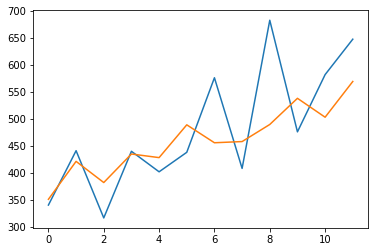

In [29]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

In [31]:
import pandas as pd
# load dataset
def parser(x):
    return datetime.strptime(x, '%Y')

batting_data_path = 'bsb_ref.csv'
# INFO:
# 101,332 Players with up to 20 features each (exluding year, including team)
# if metric not reported for player, set to 0.0 by default

df = pd.read_csv(batting_data_path)
df = df.fillna(0)

# focusing on players after 1975
df_recent_players = df[df.year_ID >= 1975] #48k players
'''
df_recent_players = df_recent_players[['year_ID', 'name_common', 'age', 'mlb_ID', 'player_ID', 'team_ID', 'stint_ID',
                                       'lg_ID', 'PA', 'G', 'Inn', 'runs_bat', 'runs_br', 'runs_dp', 'runs_field', 
                                       'runs_infield', 'runs_outfield', 'runs_catcher', 'runs_good_plays',
                                       'runs_defense', 'runs_position', 'runs_position_p', 'runs_replacement',
                                        'runs_above_rep', 'runs_above_avg', 'runs_above_avg_off', 'runs_above_avg_def',
                                       'WAA', 'WAA_off', 'WAA_def', 'WAR', 'WAR_def', 'WAR_off', 'WAR_rep',
                                       'salary', 'pitcher', 'teamRpG', 'oppRpG', 'oppRpPA_rep', 'oppRpG_rep',
                                       'pyth_exponent', 'pyth_exponent_rep', 'waa_win_perc', 'waa_win_perc_off',
                                       'waa_win_perc_def', 'waa_win_perc_rep', 'OPS_plus', 'TOB_lg', 'TB_lg']]

'''
print(df_recent_players.head(0))

Empty DataFrame
Columns: [name_common, age, mlb_ID, player_ID, year_ID, team_ID, stint_ID, lg_ID, PA, G, Inn, runs_bat, runs_br, runs_dp, runs_field, runs_infield, runs_outfield, runs_catcher, runs_good_plays, runs_defense, runs_position, runs_position_p, runs_replacement, runs_above_rep, runs_above_avg, runs_above_avg_off, runs_above_avg_def, WAA, WAA_off, WAA_def, WAR, WAR_def, WAR_off, WAR_rep, salary, pitcher, teamRpG, oppRpG, oppRpPA_rep, oppRpG_rep, pyth_exponent, pyth_exponent_rep, waa_win_perc, waa_win_perc_off, waa_win_perc_def, waa_win_perc_rep, OPS_plus, TOB_lg, TB_lg]
Index: []

[0 rows x 49 columns]


In [32]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime(x, '%Y')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


In [40]:
# load dataset
def parser(x):
    return datetime.strptime(x, '%Y')


import csv
#players = read_csv('bsb_ref.csv', parse_dates=[4], index_col=0,squeeze=True, date_parser=parser)
players = read_csv('bsb_ref.csv', parse_dates=[4], squeeze=True, date_parser=parser)
#series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], , squeeze=True, date_parser=parser)

# summarize first few rows

#original has 
'''
print(players.shape) (107211, 48)
print(players.ndim) 2
'''

players = players.fillna(0)

# focusing on players after 1975
d1 = '1975-01-01'
date = datetime.strptime(d1, '%Y-%m-%d')

df_recent_players = players[players.year_ID >= date] #48k players
print(df_recent_players.shape) #(54579, 48)
print(df_recent_players.ndim) #2

#reorder columns so date is first
df_recent_players = df_recent_players[['year_ID', 'name_common', 'age', 'mlb_ID', 'player_ID', 'team_ID', 'stint_ID',
                                       'lg_ID', 'PA', 'G', 'Inn', 'runs_bat', 'runs_br', 'runs_dp', 'runs_field', 
                                       'runs_infield', 'runs_outfield', 'runs_catcher', 'runs_good_plays',
                                       'runs_defense', 'runs_position', 'runs_position_p', 'runs_replacement',
                                        'runs_above_rep', 'runs_above_avg', 'runs_above_avg_off', 'runs_above_avg_def',
                                       'WAA', 'WAA_off', 'WAA_def', 'WAR', 'WAR_def', 'WAR_off', 'WAR_rep',
                                       'salary', 'pitcher', 'teamRpG', 'oppRpG', 'oppRpPA_rep', 'oppRpG_rep',
                                       'pyth_exponent', 'pyth_exponent_rep', 'waa_win_perc', 'waa_win_perc_off',
                                       'waa_win_perc_def', 'waa_win_perc_rep', 'OPS_plus', 'TOB_lg', 'TB_lg']]
                                       
print(df_recent_players.head())






(54579, 49)
2
     year_ID    name_common   age    mlb_ID  player_ID team_ID  stint_ID  \
0 2004-01-01  David Aardsma  22.0  430911.0  aardsda01     SFG         1   
1 2006-01-01  David Aardsma  24.0  430911.0  aardsda01     CHC         1   
2 2007-01-01  David Aardsma  25.0  430911.0  aardsda01     CHW         1   
3 2008-01-01  David Aardsma  26.0  430911.0  aardsda01     BOS         1   
4 2009-01-01  David Aardsma  27.0  430911.0  aardsda01     SEA         1   

  lg_ID   PA   G  ...  oppRpG_rep  pyth_exponent  pyth_exponent_rep  \
0    NL  0.0  11  ...     4.67092          1.890              1.890   
1    NL  3.0  43  ...     4.86457          1.912              1.913   
2    AL  0.0   2  ...     4.85895          1.912              1.912   
3    AL  1.0   5  ...     4.69650          1.893              1.894   
4    AL  0.0   3  ...     4.79788          1.905              1.905   

   waa_win_perc  waa_win_perc_off  waa_win_perc_def  waa_win_perc_rep  \
0         0.500             0

In [41]:

#print(df_recent_players.head(9))
davidAardsmaDf = df_recent_players.head(9)
#print(davidAardsmaDf.head(0))
print(davidAardsmaDf.head(1))

     year_ID    name_common   age    mlb_ID  player_ID team_ID  stint_ID  \
0 2004-01-01  David Aardsma  22.0  430911.0  aardsda01     SFG         1   

  lg_ID   PA   G  ...  oppRpG_rep  pyth_exponent  pyth_exponent_rep  \
0    NL  0.0  11  ...     4.67092           1.89               1.89   

   waa_win_perc  waa_win_perc_off  waa_win_perc_def  waa_win_perc_rep  \
0           0.5               0.5               0.5               0.5   

   OPS_plus  TOB_lg  TB_lg  
0       0.0     0.0    0.0  

[1 rows x 49 columns]


In [72]:

#cast all to same type float
davidAardsmaDf['G'] = davidAardsmaDf['G'].astype(float)
davidAardsmaDf['stint_ID'] = davidAardsmaDf['stint_ID'].astype(float)
davidAardsmaDf = davidAardsmaDf.drop(["team_ID", "lg_ID", "pitcher", "player_ID", "name_common"], axis=1)

print(davidAardsmaDf.dtypes, davidAardsmaDf)

KeyError: "['team_ID' 'lg_ID' 'pitcher' 'player_ID' 'name_common'] not found in axis"

In [71]:
from matplotlib import pyplot
smallDF = davidAardsmaDf
# line plot

#print(series)

# delete columns using the columns parameter of drop
#davidAardsmaDf = davidAardsmaDf.drop(columns="name_common")

# Delete multiple columns from the dataframe"
davidAardsmaDf = davidAardsmaDf.drop(["team_ID", "lg_ID", "pitcher", "player_ID", "name_common"], axis=1)
davidAardsmaDf.plot()
pyplot.show()


'''smallDF = smallDF.drop(['year_ID','name_common', 'age', 'mlb_ID', 'player_ID', 'team_ID', 'stint_ID',
                                       'lg_ID', 'PA', 'G', 'Inn', 'runs_bat', 'runs_br', 'runs_dp', 'runs_field', 
                                       'runs_infield', 'runs_outfield', 'runs_catcher', 'runs_good_plays',
                                       'runs_defense', 'runs_position', 'runs_position_p', 'runs_replacement',
                                        'runs_above_rep', 'runs_above_avg', 'runs_above_avg_off', 'runs_above_avg_def',
                                       'WAA', 'WAA_off', 'WAA_def', 'WAR_def', 'WAR_off', 'WAR_rep',
                                       'salary', 'pitcher', 'teamRpG', 'oppRpG', 'oppRpPA_rep', 'oppRpG_rep',
                                       'pyth_exponent', 'pyth_exponent_rep', 'waa_win_perc', 'waa_win_perc_off',
                                       'waa_win_perc_def', 'waa_win_perc_rep', 'OPS_plus', 'TOB_lg', 'TB_lg'], axis=1)
'''
print(smallDF)

ValueError: view limit minimum -137605.0 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [44]:
'''print(len(davidAardsmaDf.columns))
ls = list(davidAardsmaDf.head(0))
print(len(ls), ls) '''

'print(len(davidAardsmaDf.columns))\nls = list(davidAardsmaDf.head(0))\nprint(len(ls), ls) '

In [60]:
import numpy as np
# transform data to be stationary

raw_values = smallDF.values
#s_values = series.values


oneDim = np.stack(raw_values, axis =1)

print(raw_values)

raw_values = oneDim[0]
print(raw_values)
diff_values = difference(raw_values, 1)

[[ 0.  ]
 [-0.04]
 [ 0.  ]
 [-0.02]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [-0.01]]
[ 0.   -0.04  0.   -0.02  0.    0.    0.    0.   -0.01]


supervised_values:  8 [[ 0.   -0.04]
 [-0.04  0.04]
 [ 0.04 -0.02]
 [-0.02  0.02]
 [ 0.02  0.  ]
 [ 0.    0.  ]
 [ 0.    0.  ]
 [ 0.   -0.01]]
Year=1, Predicted=-0.046001, Expected=0.000000
Year=2, Predicted=0.005375, Expected=0.000000
Year=3, Predicted=-0.044539, Expected=0.000000
Year=4, Predicted=-0.000795, Expected=-0.010000
Test RMSE: 0.032


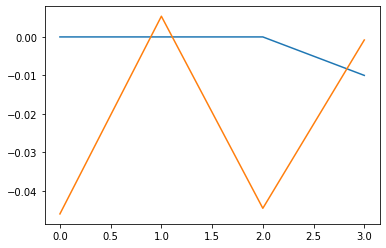

In [65]:

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
print("supervised_values: ", len(supervised_values), supervised_values)
train, test = supervised_values[0:-4], supervised_values[-4:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Year=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-4:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-4:])
pyplot.plot(predictions)
pyplot.show()